### **Load packages & functions**

In [1]:
suppressMessages(library(extRemes))

prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

### **Load data**

In [2]:
ts <- read.csv("ts/EA-drought_pr-ond_cpc.dat", comment.char = "#", sep = " ", header = F, col.names = c("year", "tmax"))
gmst <- read.fwf("/home/clair/Data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))

# load detrended (NOT RESCALED) Nino3.4 timeseries, select September only
nino <- read.csv("data/nino3.4_detrended.csv")
nino_sep <- nino[substr(nino$time,6,7) == "09",]
nino_sep$year <- substr(nino_sep$time,1,4)

In [3]:
# merge data & covariates together
df <- merge(nino_sep[,c("year", "nino3.4_det")], merge(gmst, ts))

### **Fit model with & without Nino3.4 covariate**

In [9]:
mdl_gmst_nino <- fevd(tmax, df, location.fun = ~ gmst + nino3.4_det)
mdl_gmst <- fevd(tmax, df, location.fun = ~ gmst)
mdl_nino <- fevd(tmax, df, location.fun = ~ nino3.4_det)

In [34]:
lr.test(mdl_gmst_nino, mdl_gmst) # any evidence for sufficient improvement in the model to include the extra covariate?


	Likelihood-ratio Test

data:  tmaxtmax
Likelihood-ratio = 2.1998, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.138
alternative hypothesis: greater


### **Compare fitted model over time**

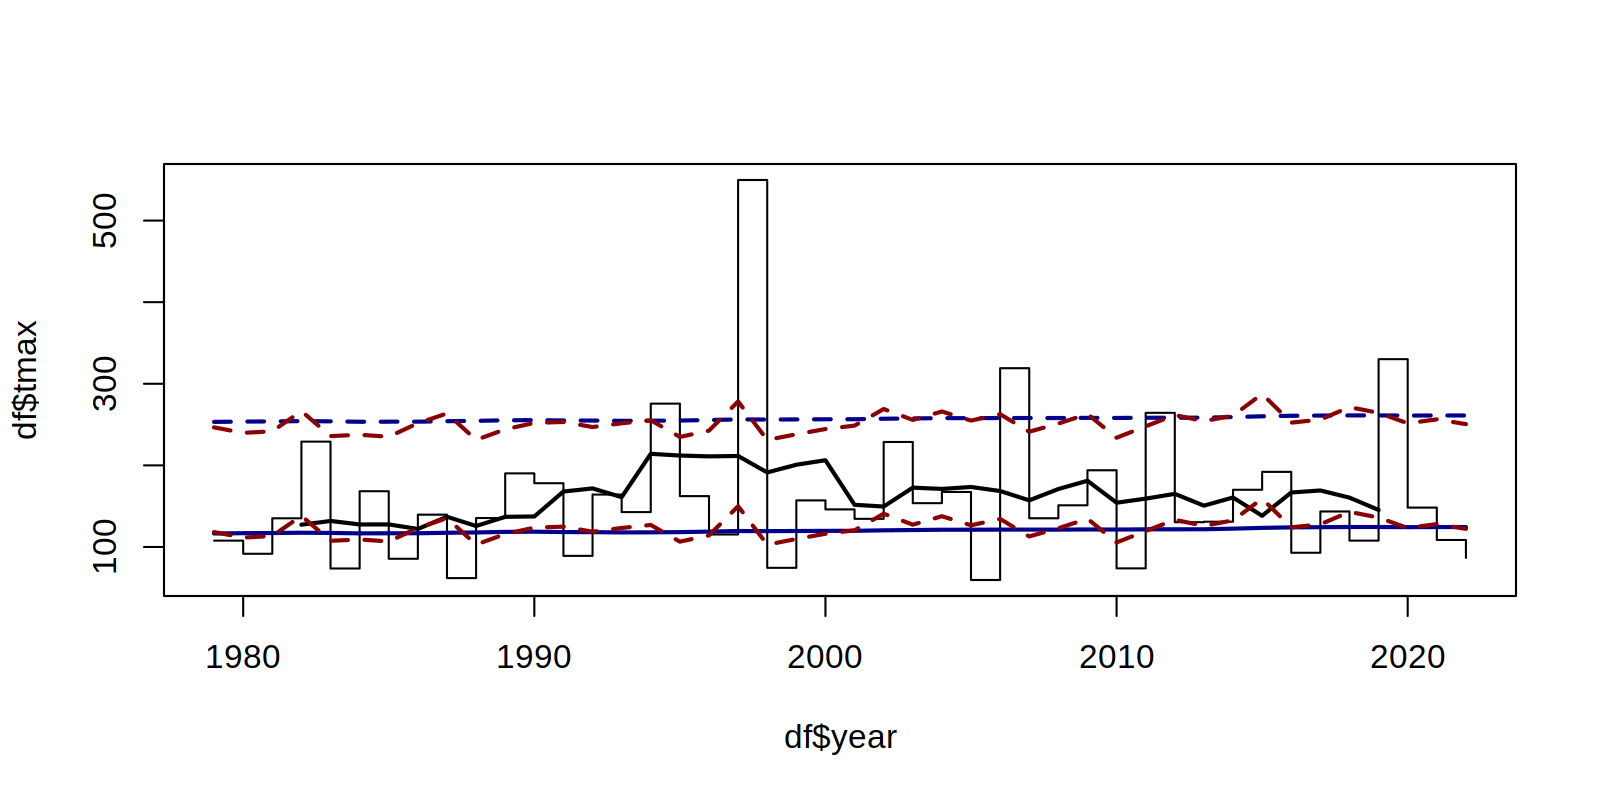

In [33]:
# compare fitted models with & without detrended Nino3.4 index
prep_window(c(1,2)); par(mfrow = c(1,1))
nd <- 7

plot(df$year, df$tmax, type = "s")
lines(df$year, filter(df$tmax, rep(1/nd, nd)), lwd = 2)

lines(df$year, findpars(mdl_gmst)$location, col = "darkblue", lwd = 2)
lines(df$year, return.level(mdl_gmst, 10), col = "darkblue", lwd = 2, lty = 2)

lines(df$year, findpars(mdl_gmst_nino)$location, col = "darkred", lwd = 2, lty = 2)
lines(df$year, return.level(mdl_gmst_nino, 10), col = "darkred", lwd = 2, lty = 2)

In [30]:
return.level(mdl_gmst, 10)

fevd(x = tmax, data = df, location.fun = ~gmst)
get(paste("return.level.fevd.", newcl, sep = ""))(x = x, return.period = return.period)

 GEV model fitted to  tmax df 
Data are assumed to be  non-stationary 
[1] "Covariate data = df"
[1] "Return Levels for period units in years"
      10-year level
 [1,]      253.3084
 [2,]      253.6769
 [3,]      253.8632
 [4,]      254.2467
 [5,]      253.9810
 [6,]      253.4541
 [7,]      253.5548
 [8,]      253.5741
 [9,]      254.1738
[10,]      254.5723
[11,]      255.2663
[12,]      255.4805
[13,]      255.0499
[14,]      254.9471
[15,]      254.6001
[16,]      254.7051
[17,]      254.9835
[18,]      255.5812
[19,]      256.3352
[20,]      256.1745
[21,]      256.3395
[22,]      256.5237
[23,]      256.5751
[24,]      257.1813
[25,]      257.5455
[26,]      257.9053
[27,]      257.9310
[28,]      258.0510
[29,]      258.0703
[30,]      258.0253
[31,]      258.2523
[32,]      258.1131
[33,]      258.3851
[34,]      258.4323
[35,]      258.4858


In [27]:
findpars(mdl_gmst)$location

1        2        3        4        5        6        7        8 
116.5486 116.9170 117.1034 117.4868 117.2212 116.6942 116.7949 116.8142 
       9       10       11       12       13       14       15       16 
117.4140 117.8124 118.5064 118.7206 118.2901 118.1873 117.8403 117.9452 
      17       18       19       20       21       22       23       24 
118.2237 118.8213 119.5753 119.4147 119.5796 119.7638 119.8152 120.4215 
      25       26       27       28       29       30       31       32 
120.7856 121.1455 121.1712 121.2911 121.3104 121.2654 121.4925 121.3533 
      33       34       35       36       37       38       39       40 
121.6253 121.6724 121.7260 122.4607 123.4032 124.0308 124.2857 124.4871 
      41       42       43       44 
124.4850 124.2900 124.4078 124.4136